# Modelling - 2nd Run

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
import pickle

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim as p_gensim

import pathlib
%matplotlib inline

In [2]:
final_df = pd.read_csv('./dataframes/final_df.csv',index_col=0)

In [3]:
final_df = final_df[['review','clean_reviews','2gram_reviews','3gram_reviews']]
final_df.head()

,review,clean_reviews,2gram_reviews,3gram_reviews
0,Well for me game still tons of work. i like it...,"['tons', 'work', 'recommend', '1', 'diplomacy'...","['ton', 'work', 'recommend', 'diplomacy', 'jok...","['ton', 'work', 'recommend', 'diplomacy', 'jok..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"['pursued', 'lu', 'bu', 'lu', 'bu']","['pursued', 'lu_bu', 'lu_bu']","['pursued', 'lu_bu', 'lu_bu']"
2,Absolutely great game. \nAll the new diplomacy...,"['absolutely', 'great', 'game', 'new', 'diplom...","['absolutely', 'great', 'new', 'diplomacy_opti...","['absolutely', 'great_game', 'new', 'diplomacy..."
3,A fine blend of Warhammer I/II: Total War and ...,"['fine', 'blend', 'warhammer', 'iii', 'total',...","['fine', 'blend', 'warhammer', 'total_war', 's...","['fine', 'blend', 'warhammer', 'total_war', 's..."
4,Innovative Total Game that has lots of persona...,"['innovative', 'total', 'lots', 'personality',...","['innovative', 'total', 'lot', 'personality', ...","['innovative', 'total', 'lot', 'personality', ..."


In [4]:
final_df['clean_reviews'] = final_df['clean_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) #n-grams underscores must be preserved for readability
final_df['2gram_reviews'] = final_df['2gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
final_df['3gram_reviews'] = final_df['3gram_reviews'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 
#Reading in the DF from a CSV turned the list of words in each cell into string, so we have to remove the punctuation and split them again

In [5]:
final_df.head()

,review,clean_reviews,2gram_reviews,3gram_reviews
0,Well for me game still tons of work. i like it...,"[tons, work, recommend, 1, diplomacy, joke, wo...","[ton, work, recommend, diplomacy, joke, work, ...","[ton, work, recommend, diplomacy, joke, work, ..."
1,I pursued Lu Bu. Now I [b]AM[/b] LU BU.,"[pursued, lu, bu, lu, bu]","[pursued, lu_bu, lu_bu]","[pursued, lu_bu, lu_bu]"
2,Absolutely great game. \nAll the new diplomacy...,"[absolutely, great, game, new, diplomacy, opti...","[absolutely, great, new, diplomacy_options, de...","[absolutely, great_game, new, diplomacy_option..."
3,A fine blend of Warhammer I/II: Total War and ...,"[fine, blend, warhammer, iii, total, war, shog...","[fine, blend, warhammer, total_war, shogun, to...","[fine, blend, warhammer, total_war, shogun, to..."
4,Innovative Total Game that has lots of persona...,"[innovative, total, lots, personality, brings,...","[innovative, total, lot, personality, brings, ...","[innovative, total, lot, personality, brings, ..."


# LDA Model - 3grams - Filter the Bag of Words

In [144]:
#build dictionary and corpus from 3gram dataset -- this time with filter_extremes

documents = list(final_df['3gram_reviews'])
dictionary = gensim.corpora.Dictionary(documents)
dictionary.filter_extremes(no_below = 5,no_above=0.7)
corpus = [dictionary.doc2bow(word) for word in documents]

In [146]:
# LDA model parameters.
num_topics = 10
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [147]:
%time ldamodel1 = LdaMulticore(corpus, num_topics=num_topics, id2word = dictionary, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel1.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

Wall time: 1min 48s
total_war battle best good great campaign amazing played time better gameplay far graphic shogun strategy
china history love lu_bu three_kingdoms total_war play liu_bei cao_cao dynasty_warriors chinese people want know good
total_war diplomacy great good character warhammer battle feel fun play campaign new three_kingdoms setting game
good turn campaign play faction battle ai crash issue thing dlc hour got problem patch
total_war played shogun game far best_total_war warhammer new series three_kingdoms love fan playing total_war_games play
play time want good dlc lot fan recommend hour series ca thing need right wanted
general character faction unit army battle building diplomacy vassal time campaign ai city map feel
unit army general faction battle ai want warhammer need hero total_war diplomacy cavalry enemy food
unit battle feel army campaign good general time ai character enemy way mode actually mechanic
tw total_war diplomacy faction historical new series title

In [148]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=ldamodel1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda1)


Perplexity:  -7.276442339360492

Coherence Score:  0.4059020111797983


In [149]:
pyLDAvis.enable_notebook()
vis = p_gensim.prepare(ldamodel1, corpus, dictionary)
vis

C:\Users\Alfred\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.102795 -0.096388       1        1  15.927121
0     -0.110597 -0.034026       2        1  15.884527
6      0.160154 -0.047090       3        1  13.056067
7      0.127084 -0.089291       4        1  12.793131
4     -0.215106 -0.024283       5        1  10.123169
1      0.012961  0.223132       6        1   9.435456
3      0.116555  0.042216       7        1   8.674814
8      0.087788 -0.071965       8        1   5.905112
9     -0.047703 -0.065506       9        1   4.968741
5     -0.028341  0.163201      10        1   3.231857, topic_info=     Category         Freq            Term        Total  loglift  logprob
140   Default   728.000000            unit   728.000000  30.0000  30.0000
82    Default  1466.000000       total_war  1466.000000  29.0000  29.0000
227   Default   317.000000              tw   317.000000  28.0000  28.0000
55    Default   663.000000            play   663.000000  27.0000  27.0000
404   Default   530.000000          played   530.000000  26.0000  26.0000
1     Default   517.000000            army   517.000000  25.0000  25.0000
137   Default   435.000000          shogun   435.000000  24.0000  24.0000
119   Default   954.000000          battle   954.000000  23.0000  23.0000
91    Default   290.000000            want   290.000000  22.0000  22.0000
21    Default   637.000000       diplomacy   637.000000  21.0000  21.0000
25    Default   596.000000         faction   596.000000  20.0000  20.0000
265   Default   243.000000  best_total_war   243.000000  19.0000  19.0000
487   Default   338.000000             fan   338.000000  18.0000  18.0000
225   Default   390.000000          series   390.000000  17.0000  17.0000
154   Default   655.000000         general   655.000000  16.0000  16.0000
260   Default   595.000000            time   595.000000  15.0000  15.0000
125   Default   446.000000             far   446.000000  14.0000  14.0000
116   Default   536.000000       warhammer   536.000000  13.0000  13.0000
107   Default   498.000000            game   498.000000  12.0000  12.0000
122   Default   612.000000       character   612.000000  11.0000  11.0000
104   Default   580.000000            feel   580.000000  10.0000  10.0000
424   Default   223.000000           china   223.000000   9.0000   9.0000
97    Default   109.000000           lu_bu   109.000000   8.0000   8.0000
150   Default   187.000000             dlc   187.000000   7.0000   7.0000
512   Default   188.000000         history   188.000000   6.0000   6.0000
129   Default   241.000000            hour   241.000000   5.0000   5.0000
414   Default   367.000000            best   367.000000   4.0000   4.0000
206   Default   635.000000           great   635.000000   3.0000   3.0000
171   Default   837.000000            good   837.000000   2.0000   2.0000
131   Default   448.000000            love   448.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
1816  Topic10    15.619026           steam    38.974308   2.5177  -5.2367
308   Topic10    21.060108              im    69.077835   2.2443  -4.9378
150   Topic10    38.175278             dlc   187.600647   1.8400  -4.3430
55    Topic10    85.022926            play   663.952026   1.3768  -3.5423
91    Topic10    48.418095            want   290.939514   1.6389  -4.1053
59    Topic10    32.433247       recommend   175.040558   1.7463  -4.5060
260   Topic10    58.631794            time   595.776184   1.1135  -3.9139
33    Topic10    18.421144             guy    73.806213   2.0442  -5.0717
634   Topic10    16.907515          bought    63.956993   2.1017  -5.1574
179   Topic10    14.803594           price    53.228477   2.1524  -5.2903
1245  Topic10    24.665590           right   149.974899   1.6271  -4.7798
129   Topic10    30.265358            hour   241.593170   1.3549  -4.5752
1476  Topic10    16.371483     multiplayer    66.8920

In [152]:
ldamodel1.save('./models/clean/clean1.model')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [153]:
#build dictionary and corpus from 3gram dataset -- this time with filter_extremes

documents = list(final_df['3gram_reviews'])
dictionary2 = gensim.corpora.Dictionary(documents)
dictionary2.filter_extremes()
corpus2 = [dictionary2.doc2bow(word) for word in documents]

In [154]:
# LDA model parameters.
num_topics = 10
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [155]:
%time ldamodel2 = gensim.models.ldamulticore.LdaMulticore(corpus2, num_topics=num_topics, id2word = dictionary2, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel2.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

Wall time: 1min 43s
battle campaign total_war feel good time lot warhammer play character diplomacy ai great unit general
total_war played game shogun far series fan best_total_war warhammer new three_kingdoms best great love tw
good great love total_war best play amazing finally better crash ca time graphic update far
china lu_bu got war cao_cao liu_bei play sun_jian emperor year love warlord chinese kingdom crash
faction character fun game good feel recommend play lot change dlc way nice strategy different
unit army general faction ai turn building battle diplomacy character enemy need thing city time
good novel history diplomacy chinese age bit total_war strategy romance_three_kingdoms battle graphic story solid epic
campaign friend yuan_shao character total_war battle fun coalition faction coop turn enemy playing three_kingdoms played
yes total_war duel enemy three_kingdoms battle time general god lu_bu problem dead army company change
total_war new play dlc time great want good bl

In [156]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=ldamodel1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda1 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -7.248892291032461

Coherence Score:  0.37892300716172256


In [157]:
pyLDAvis.enable_notebook()
vis = p_gensim.prepare(ldamodel2, corpus, dictionary)
vis

C:\Users\Alfred\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043717  0.069955       1        1  36.916431
5      0.134356  0.147337       2        1  21.690985
1     -0.212309  0.010962       3        1  14.965874
4     -0.070111  0.085787       4        1   6.262193
2     -0.126380 -0.126778       5        1   4.205195
3      0.171623 -0.184444       6        1   3.849775
7      0.103358  0.022314       7        1   3.717175
9     -0.064532 -0.091719       8        1   3.507925
6     -0.012096  0.067970       9        1   2.601674
8      0.119808 -0.001383      10        1   2.282774, topic_info=     Category         Freq            Term        Total  loglift  logprob
82    Default  1454.000000       total_war  1454.000000  30.0000  30.0000
171   Default   835.000000            good   835.000000  29.0000  29.0000
206   Default   630.000000           great   630.000000  28.0000  28.0000
25    Default   599.000000         faction   599.000000  27.0000  27.0000
111   Default   524.000000             new   524.000000  26.0000  26.0000
140   Default   735.000000            unit   735.000000  25.0000  25.0000
55    Default   663.000000            play   663.000000  24.0000  24.0000
131   Default   445.000000            love   445.000000  23.0000  23.0000
1     Default   521.000000            army   521.000000  22.0000  22.0000
154   Default   658.000000         general   658.000000  21.0000  21.0000
107   Default   498.000000            game   498.000000  20.0000  20.0000
119   Default   960.000000          battle   960.000000  19.0000  19.0000
122   Default   612.000000       character   612.000000  18.0000  18.0000
260   Default   597.000000            time   597.000000  17.0000  17.0000
414   Default   362.000000            best   362.000000  16.0000  16.0000
137   Default   437.000000          shogun   437.000000  15.0000  15.0000
201   Default   199.000000            duel   199.000000  14.0000  14.0000
404   Default   529.000000          played   529.000000  13.0000  13.0000
424   Default   220.000000           china   220.000000  12.0000  12.0000
302   Default   463.000000             fun   463.000000  11.0000  11.0000
125   Default   446.000000             far   446.000000  10.0000  10.0000
331   Default   687.000000        campaign   687.000000   9.0000   9.0000
138   Default   465.000000  three_kingdoms   465.000000   8.0000   8.0000
265   Default   243.000000  best_total_war   243.000000   7.0000   7.0000
23    Default   198.000000           enemy   198.000000   6.0000   6.0000
21    Default   638.000000       diplomacy   638.000000   5.0000   5.0000
225   Default   392.000000          series   392.000000   4.0000   4.0000
487   Default   338.000000             fan   338.000000   3.0000   3.0000
150   Default   184.000000             dlc   184.000000   2.0000   2.0000
195   Default   243.000000         amazing   243.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
1323  Topic10    11.423598         company    28.303444   2.8725  -5.2019
1741  Topic10     6.498337        charging    14.244207   2.9950  -5.7660
673   Topic10    14.707799             god    53.276676   2.4927  -4.9492
201   Topic10    29.647556            duel   199.241943   1.8746  -4.2482
1648  Topic10     6.863704            knew    16.723255   2.8892  -5.7113
626   Topic10     7.897706             won    21.866697   2.7614  -5.5710
1736  Topic10     7.576968           zhang    20.631149   2.7781  -5.6124
23    Topic10    22.182003           enemy   198.887650   1.5863  -4.5383
927   Topic10     8.555971           night    29.903767   2.5284  -5.4909
1852  Topic10     9.200899            stop    36.168526   2.4109  -5.4182
97    Topic10    14.139194           lu_bu   106.850182   1.7573  -4.9886
2324  Topic10     8.488139          buy_it    31.036598   2.4833  -5.4989
82    Topic10    36.515862       total_war  1454.1860

In [158]:
#code from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):   #Using the first dictionary and corpus because it seems to output more coherent topics
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

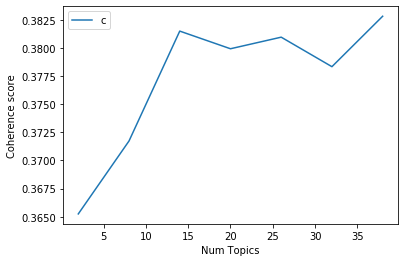

In [159]:
limit=40
start=2
step=6

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=list(final_df['3gram_reviews']), start=start, limit=limit, step=step)

# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
#build dictionary and corpus from 3gram dataset -- NO filter_extremes

documents = list(final_df['3gram_reviews'])
dictionary2 = gensim.corpora.Dictionary(documents)
corpus2 = [dictionary2.doc2bow(word) for word in documents]

In [122]:
# LDA model parameters.
num_topics = 15
passes = 100
eval_every = None #Evaluation will happen later so no need to evaluate while training

In [123]:
%time ldamodel2 = LdaMulticore(corpus2, num_topics=num_topics, id2word = dictionary2, passes=passes, alpha='asymmetric',eval_every=eval_every,workers=3)

# Check resulting topics.
topic_list = ldamodel2.print_topics(num_topics=num_topics, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

Wall time: 1min 36s
best_total_war total_war time great fun lu_bu far good played play shogun yuan_shao cao_cao campaign got
total_war played game far play love good best fan three_kingdoms new great shogun ca time
good army cao_cao sun_jian fps empire come china han lu_bu sun_ce rice fast emperor betray
total_war battle character diplomacy campaign feel warhammer play unit faction general great series new shogun
crash ca patch fix issue update time amazing review bug play chinese hour work blood
total_war battle ai played look run feel general shogun army good little know fun ca
alot fun game gameplay hour tw play day good work need x general campaign battle
good great better new warhammer diplomacy feel total_war campaign bit ui tw nice think need
unit army general faction ai battle building turn enemy good thing need campaign diplomacy time
battle good play yes time need combat hero era history look thing know graphic love


In [124]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=ldamodel1, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda2 = coherence_model_lda1.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -8.090059680957241

Coherence Score:  0.37892300716172256


In [125]:
pyLDAvis.enable_notebook()
vis = p_gensim.prepare(ldamodel2, corpus2, dictionary2)
vis

C:\Users\Alfred\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.135647  0.064997       1        1  32.093063
1     -0.281759 -0.150059       2        1  18.140415
2     -0.133284  0.068986       3        1  15.594174
5     -0.031460  0.166388       4        1   7.195213
7     -0.074432  0.032001       5        1   5.979432
10     0.041909  0.035199       6        1   3.575654
3      0.016272  0.034616       7        1   3.094483
4      0.092551 -0.028504       8        1   2.402208
13     0.034367 -0.024783       9        1   2.193938
6      0.070199 -0.107399      10        1   1.982062
8      0.055628 -0.061541      11        1   1.800784
12     0.098873  0.015118      12        1   1.684235
14     0.013758  0.001658      13        1   1.610724
11     0.103631 -0.010993      14        1   1.396009
9      0.129394 -0.035682      15        1   1.257610, topic_info=     Category         Freq            Term        Total  loglift  logprob
189   Default   788.000000            good   788.000000  30.0000  30.0000
89    Default  1430.000000       total_war  1430.000000  29.0000  29.0000
156   Default   711.000000            unit   711.000000  28.0000  28.0000
227   Default   609.000000           great   609.000000  27.0000  27.0000
132   Default   588.000000       character   588.000000  26.0000  26.0000
291   Default   566.000000            time   566.000000  25.0000  25.0000
59    Default   631.000000            play   631.000000  24.0000  24.0000
296   Default   239.000000  best_total_war   239.000000  23.0000  23.0000
152   Default   425.000000          shogun   425.000000  22.0000  22.0000
29    Default   575.000000         faction   575.000000  21.0000  21.0000
1     Default   494.000000            army   494.000000  20.0000  20.0000
135   Default   437.000000             far   437.000000  19.0000  19.0000
462   Default   517.000000          played   517.000000  18.0000  18.0000
94    Default   273.000000            turn   273.000000  17.0000  17.0000
474   Default   352.000000            best   352.000000  16.0000  16.0000
251   Default   382.000000          series   382.000000  15.0000  15.0000
326   Default   159.000000            nice   159.000000  14.0000  14.0000
171   Default   632.000000         general   632.000000  13.0000  13.0000
129   Default   922.000000          battle   922.000000  12.0000  12.0000
0     Default   450.000000              ai   450.000000  11.0000  11.0000
558   Default   331.000000             fan   331.000000  10.0000  10.0000
117   Default   491.000000            game   491.000000   9.0000   9.0000
254   Default   309.000000              tw   309.000000   8.0000   8.0000
145   Default   432.000000            love   432.000000   7.0000   7.0000
215   Default   235.000000         amazing   235.000000   6.0000   6.0000
148   Default   303.000000            need   303.000000   5.0000   5.0000
26    Default   189.000000           enemy   189.000000   4.0000   4.0000
153   Default   451.000000  three_kingdoms   451.000000   3.0000   3.0000
101   Default   176.000000             war   176.000000   2.0000   2.0000
533   Default   381.000000           thing   381.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3489  Topic15     3.966563         penalty    12.238955   3.2492  -5.7918
4278  Topic15     2.067971        come_out     5.783272   3.3476  -6.4432
1433  Topic15     5.210683            beat    23.281445   2.8790  -5.5190
1203  Topic15    11.254021       yuan_shao    75.898140   2.4673  -4.7490
2770  Topic15     3.299482          waited    12.498099   3.0441  -5.9760
801   Topic15     5.981542             god    49.164646   2.2695  -5.3811
94    Topic15    12.178195            turn   273.704376   1.2636  -4.6701
8     Topic15     3.274399        breaking    18.022713   2.6705  -5.9836
1188  Topic15     5.152498         emperor    64.659958   1.8463  -5.5303
1155 

In [131]:
ldamodel1.save('noclean_1.lda')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [132]:
ldamodel2.save('noclean_2.lda')

C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\Alfred\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# First Run in Summary

In my first run I had 10 topics and I was able to identify 5 generally coherent topics from the 10 provided.

Unfortunately, I have LOST them completely in this first run. The saved models above do not include that one good model. I will try again after cleaning out infrequent terms from the corpus.


These were the topics:

1. **Series Authenticity**</br>
(Topic 1) Game's authenticity compared to other titles in the Total War series (Important because target market is full of hardcore history/ROTK buffs)

2. **Strategic Gameplay**</br>
(Topic 2) Gameplay on the strategic scale, inclusive of new features e.g. revamped Diplomacy, Romance/Records mode selection

3. **Tactical Gameplay**</br>
(Topic 3) Gameplay of individual battles and managing individual cities

4. **Historical/Cultural Authenticity**</br>
(Topic 4) Game's authenticity compared to source material. Based on Records and Romance of the Three Kingdoms, historical records and a novel respectively.

5. **Faction/Character Playstyle**</br>
(Topics 6 and 7) Each faction and character has special abilities. Liu Bei appears a lot because he is written as a virtuous hero in Romance of the Three Kingdoms. Also, his special passive ability is extremely powerful. (=50% upkeep cost for militia units, so theoretically can field 2x the number of armies as any other faction)


The other topics are not as coherent, and their term frequencies are quite low.

There are a few problems, and the following fixes are needed:

1. Make n-grams BEFORE lemmatisation and removal of numbers, to allow n-grams to include numbers. (Game names in the series can also then be identified)
2. Remove Chinese text; it appears in some of the other topics
3. Remove single-character text; it is unhelpful (e.g. i, u, x)
4. Remove low-frequency terms?
5. 

Decided not to use TF-IDF because "LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
Source: https://stackoverflow.com/a/44789327/6470915

### References

https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/